# Implementing a CNNGAN with pytroch

## 1. Import and Preprocessing
### a) Importing modules

In [1]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load required packages - deep learning 
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
print(f"tensorflow: {torch.__version__}")
import sys
print(f"python: {sys.version[:5]}")

tensorflow: 1.8.1+cu102
python: 3.7.5


### b) Importing the data

In [147]:
#download and save to file
#urllib.request.urlretrieve(
#    "https://media.githubusercontent.com/media/mmeierer/CNN---TensorFlow-vs-PyTorch/main/fashion-mnist_train.csv",
#    "fashion-mnist_train2.csv")

In [3]:
train_data = pd.read_csv('fashion-mnist_train2.csv')
#test_data = pd.read_csv('fashion-mnist_test.csv')

In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train_images = train_data.iloc[:1000,1:]
print( train_images.iloc[-1])
train_labels = train_data.iloc[:,0]
#test_images = test_data.iloc[:,1:]
#test_labels = test_data.iloc[:,0]

pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 999, Length: 784, dtype: int64


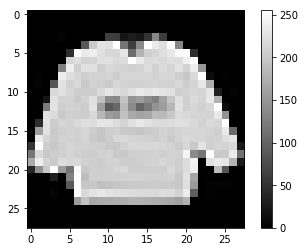

In [11]:
plt.figure()
plt.imshow(train_images.values[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c) Data preparation

In [12]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [13]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [14]:
# use maximum normalization
train_images = train_images / np.float32(255)
#test_images = test_images / np.float32(255)

In [15]:
train_images.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0



## 2. Model specific data preparation (tensorflow)
## a) Load the data

In [16]:
x_train_pt = torch.from_numpy(train_images.values.reshape((-1, 1, 28, 28)))
y_train_pt = torch.from_numpy(train_labels.values)
#x_test_pt = torch.from_numpy(test_images.values.reshape((-1, 1, 28, 28)))
#y_test_pt = torch.from_numpy(test_labels.values)

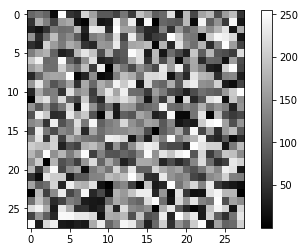

In [17]:
# use random seed to create fake input data
seed = torch.rand((28,28))
seed_im = seed.numpy() * 255
plt.figure()
plt.imshow(seed_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### b) Tensor view of the data

In [18]:
x_train_pt.shape

torch.Size([1000, 1, 28, 28])

In [19]:
seed.shape

torch.Size([28, 28])

In [20]:
x_test_pt.shape

NameError: name 'x_test_pt' is not defined

In [21]:
x_train_pt[0][0][5]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1843, 0.9882, 0.9176, 0.9333,
        0.8784, 0.8431, 0.8431, 0.8980, 0.4235, 0.7059, 0.8118, 0.8392, 0.8784,
        0.9059, 0.9765, 0.9961, 0.1765, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], dtype=torch.float64)

In [22]:
y_train_pt[0]

tensor(2)

## 3. Model definition

In [23]:
def weights_init(m):
  if isinstance(m, nn.Linear):
      nn.init.uniform_(m.weight.data, -1,1)
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.Conv2d):
      nn.init.zeros_(m.bias.data)

### a.1) Generator

In [24]:
# define a reshap layer
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        res = x.view(self.shape)
        print(res.shape)
        return x.view(self.shape)
#N - batch size / sample size
#L - sequence length
#C - the number of features / channels / filters
#pytroch uses (batch, channels, h, w)

In [25]:
def generator_model():
    model = nn.Sequential()
    #model.add_module("dense1", nn.Linear(100, 7*7*64, bias=True))
    model.add_module("Conv2D1", nn.ConvTranspose2d(100, 64, 7, stride=1, padding=0, bias=True))
    model.add_module("Batchnorm1", nn.BatchNorm2d(64))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    #model.add_module("reshape", Reshape(64, 7, 7))
    
    model.add_module("Conv2D2", nn.ConvTranspose2d(64, 64, (8,8), stride=(1,1), padding=0, bias=False))
    model.add_module("Batchnorm2", nn.BatchNorm2d(64))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.ConvTranspose2d(64, 1, (15,15), stride=1, padding=0, bias=False))
    model.add_module("Batchnorm3", nn.BatchNorm2d(1))
    model.add_module("Sigmoid1", nn.Sigmoid())
    return model
generator = generator_model()
#generator.eval()

In [26]:
# generated image not trained
fake_im_not_trained = generator(torch.rand([1, 100, 1, 1]))
# check output shape of generator
fake_im_not_trained.shape

torch.Size([1, 1, 28, 28])

###  a.2) Inspect the generator model

In [27]:
print(generator)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(1, 1), bias=False)
  (Batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(64, 1, kernel_size=(15, 15), stride=(1, 1), bias=False)
  (Batchnorm3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)


In [28]:
generator.apply(weights_init)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(1, 1), bias=False)
  (Batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(64, 1, kernel_size=(15, 15), stride=(1, 1), bias=False)
  (Batchnorm3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)

### a.3) Inspect the first convolutional layer

In [29]:
generator[0].weight[0].type()

'torch.FloatTensor'

In [30]:
generator[0].weight.shape

torch.Size([100, 64, 7, 7])

In [31]:
generator[0].bias

Parameter containing:
tensor([ 0.0087, -0.0001, -0.0166,  0.0169, -0.0067, -0.0119, -0.0015, -0.0093,
         0.0063,  0.0095,  0.0172,  0.0084, -0.0109, -0.0003,  0.0069, -0.0155,
         0.0013,  0.0150, -0.0155,  0.0021, -0.0035,  0.0015, -0.0043,  0.0165,
         0.0146,  0.0114,  0.0133,  0.0069, -0.0025, -0.0119, -0.0040,  0.0060,
        -0.0165,  0.0148,  0.0091,  0.0166,  0.0141,  0.0163,  0.0127,  0.0169,
         0.0021,  0.0145,  0.0138, -0.0170, -0.0145,  0.0092, -0.0015,  0.0092,
         0.0157,  0.0161,  0.0148, -0.0042,  0.0027,  0.0109, -0.0071, -0.0095,
        -0.0032, -0.0174, -0.0054, -0.0125, -0.0099,  0.0033,  0.0095,  0.0135],
       requires_grad=True)

In [32]:
generator[0].bias.shape

torch.Size([64])

### b.1) Discriminator

In [33]:
def discriminator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.Conv2d(1, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("Pooling1", nn.AvgPool2d(kernel_size=2, stride=2))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    model.add_module("Dropout1", nn.Dropout(0.3))
    
    model.add_module("Conv2D2", nn.Conv2d(2, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.Conv2d(2, 1, kernel_size=5, stride=1, padding=2))
    model.add_module("LeakyRelu3", nn.LeakyReLU())
    
    model.add_module("Flatten1", nn.Flatten())
    
    model.add_module("Dense1", nn.Linear(14*14,100))
    model.add_module("LeakyRelu4", nn.LeakyReLU())
    
    model.add_module("Dense2", nn.Linear(100,64))
    model.add_module("Tanh", nn.Tanh())
    
    model.add_module("Dense3", nn.Linear(64,1))
    model.add_module("Sigmoid", nn.Sigmoid())
    return model
discriminator = discriminator_model()
discriminator = discriminator.float()

### b.2) Inspect the discriminator model

In [34]:
print(discriminator)
discriminator(fake_im_not_trained)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=196, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)


tensor([[0.4847]], grad_fn=<SigmoidBackward>)

In [35]:
discriminator.apply(weights_init)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=196, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

### b.3) Inspect the first convolutional layer

In [36]:
discriminator[0].weight[0].type()

'torch.FloatTensor'

In [37]:
discriminator[0].weight.shape

torch.Size([2, 1, 5, 5])

In [38]:
discriminator[0].bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [39]:
discriminator[0].bias.shape

torch.Size([2])

## 4. Loss & Optimizer

### 4.a) Generator loss

In [40]:
cross_entropy = nn.BCEWithLogitsLoss()
def generator_loss(fake_output):
    return cross_entropy(torch.ones_like(fake_output), fake_output)

### 4.b) Discriminator loss

In [41]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(torch.ones_like(real_output), real_output)
    fake_loss = cross_entropy(torch.zeros_like(fake_output), fake_output)
    #total_loss = real_loss, fake_loss
    return real_loss, fake_loss

## 4.c) Optimizers

In [45]:
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

#train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy') # only for discriminator

def correct_classification(y_true, y_prob):
    assert y_true.size() == y_prob.size()
    y_prob = (y_prob > 0.5).float()
    return (y_true == y_prob).sum().item()
    #return torch.sum(y_true == y_pred)

## 5. Training

In [65]:
# This annotation causes the function to be "compiled".
#@tf.function
def train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size = 100):
    gen_loss_tot = 0
    disc_loss_tot = 0
    disc_acc_real_tot = 0
    disc_acc_fake_tot = 0
    batch = 0
    generator.train()
    discriminator.train()
    for beg_i in range(0, x_train_pt.shape[0], batch_size):
        x_train_batch_pt = x_train_pt[beg_i:beg_i + batch_size]
        y_train_batch_pt = y_train_pt[beg_i:beg_i + batch_size]

        x_fake_batch_pt = torch.rand([batch_size, 100, 1, 1])
        
        generated_images = generator(x_fake_batch_pt)
        real_output = discriminator(x_train_batch_pt.float())
        fake_output = discriminator(generated_images)
        
        # optimize generator
        generator_optimizer.zero_grad()

        gen_loss = generator_loss(fake_output.detach())
        gen_loss_tot += np.sum(gen_loss.data.numpy())
        gen_loss = torch.autograd.Variable(gen_loss, requires_grad = True)
        gen_loss.backward()
        generator_optimizer.step()
        #optimize discriminator
        
        discriminator_optimizer.zero_grad()
        
        disc_loss_real, disc_loss_fake = discriminator_loss(real_output.detach(), fake_output.detach())
        disc_loss_tot += np.sum(disc_loss_real.data.numpy())
        disc_loss_real = torch.autograd.Variable(disc_loss_real, requires_grad = True)
        disc_loss_real.backward()
        
        disc_loss_tot += np.sum(disc_loss_fake.data.numpy())
        disc_loss_fake = torch.autograd.Variable(disc_loss_fake, requires_grad = True)
        disc_loss_fake.backward()
        
        discriminator_optimizer.step()

        
        disc_acc_real_tot += correct_classification(torch.ones_like(real_output), real_output)
        disc_acc_fake_tot += correct_classification(torch.zeros_like(fake_output), fake_output)
        batch += 1
    disc_acc_real_tot = disc_acc_real_tot/x_train_pt.size(0)
    print(disc_acc_real_tot)
    disc_acc_fake_tot = disc_acc_fake_tot/x_train_pt.size(0)
    print(disc_acc_fake_tot)
    disc_acc_tot = np.mean([disc_acc_real_tot, disc_acc_fake_tot])
    return gen_loss_tot/batch, disc_loss_tot/batch, disc_acc_tot

In [66]:
train_losses_generator_pt = []
train_losses_discriminator_pt = []
#test_loss_pt = []

train_acc_discriminator_pt = []
#test_acc_pt = []

epochs = 15

for epoch in range(epochs):
    gen_loss, disc_loss, disc_acc = train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer)
    #print(loss)
    train_losses_generator_pt.append(gen_loss)
    train_losses_discriminator_pt.append(disc_loss)
    train_acc_discriminator_pt.append(disc_acc*100)


    template = ("Epoch {}, Loss_Generator: {}, Loss_Discriminator: {}, Discriminator_Accuracy: {}")
    print(template.format(epoch+1, gen_loss, disc_loss, disc_acc*100))

0.489
0.611
Epoch 1, Loss_Generator: 0.8910730481147766, Loss_Discriminator: 1.501886248588562, Discriminator_Accuracy: 55.00000000000001
0.519
0.6
Epoch 2, Loss_Generator: 0.8953931391239166, Loss_Discriminator: 1.4909544229507445, Discriminator_Accuracy: 55.95
0.491
0.592
Epoch 3, Loss_Generator: 0.8908259868621826, Loss_Discriminator: 1.5009965240955352, Discriminator_Accuracy: 54.15
0.514
0.667
Epoch 4, Loss_Generator: 0.9242148518562316, Loss_Discriminator: 1.4938180506229402, Discriminator_Accuracy: 59.050000000000004
0.524
0.627
Epoch 5, Loss_Generator: 0.9013683199882507, Loss_Discriminator: 1.4819307386875153, Discriminator_Accuracy: 57.550000000000004
0.488
0.637
Epoch 6, Loss_Generator: 0.9021043300628662, Loss_Discriminator: 1.5111374795436858, Discriminator_Accuracy: 56.25
0.508
0.618
Epoch 7, Loss_Generator: 0.8903283476829529, Loss_Discriminator: 1.4985381364822388, Discriminator_Accuracy: 56.3
0.482
0.635
Epoch 8, Loss_Generator: 0.9113288164138794, Loss_Discriminator: 

### b) Training progress

In [67]:
print(train_acc_discriminator_pt)

[55.00000000000001, 55.95, 54.15, 59.050000000000004, 57.550000000000004, 56.25, 56.3, 55.85, 54.05, 54.2, 56.65, 57.15, 54.55, 56.099999999999994, 56.35]


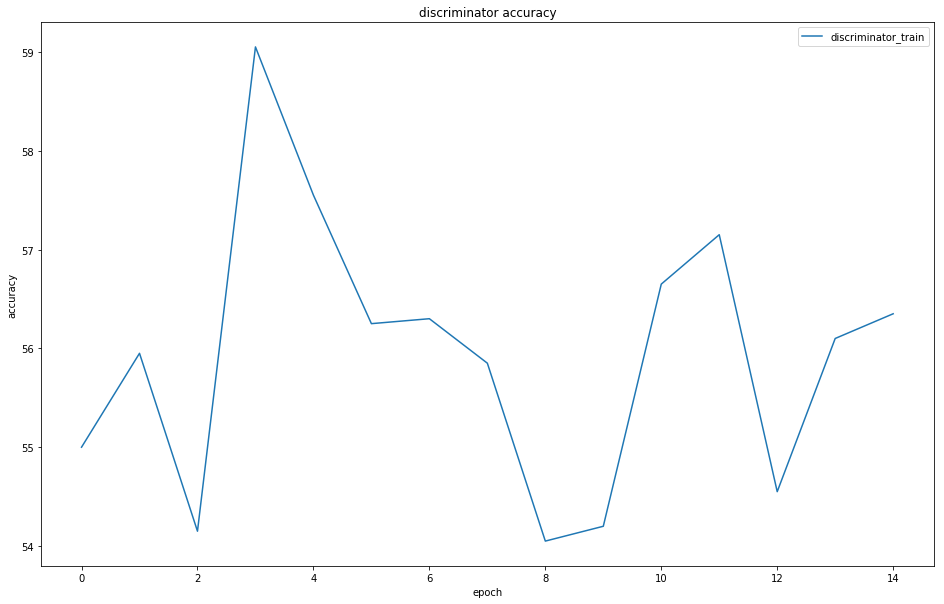

In [68]:
plt.figure(figsize=(16,10))
plt.plot(train_acc_discriminator_pt)
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['discriminator_train'], loc='upper right')
plt.show()

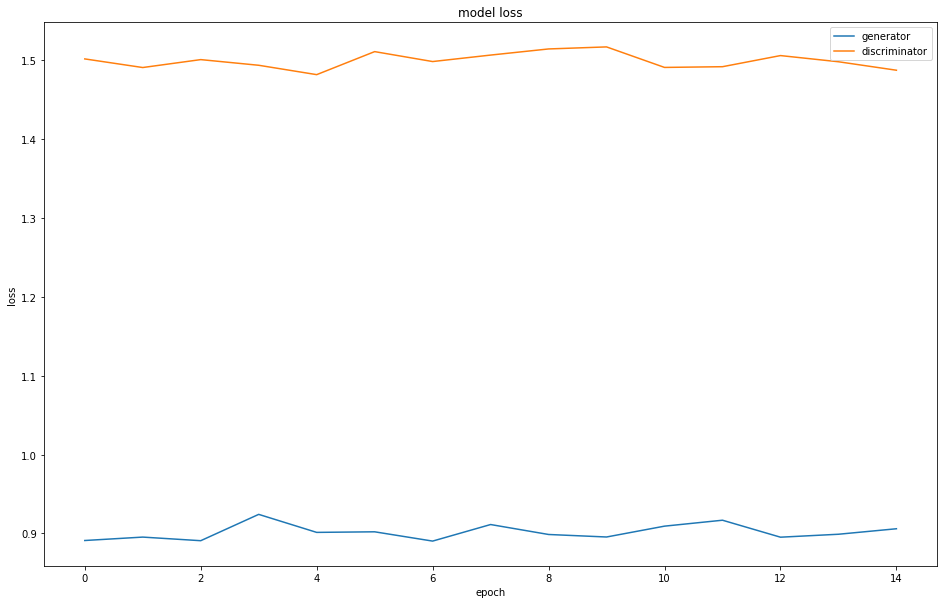

In [69]:
plt.figure(figsize=(16,10))
plt.plot(train_losses_generator_pt)
plt.plot(train_losses_discriminator_pt)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper right')
plt.show()

In [70]:
print(train_losses_generator_pt)
print(train_losses_discriminator_pt)

[0.8910730481147766, 0.8953931391239166, 0.8908259868621826, 0.9242148518562316, 0.9013683199882507, 0.9021043300628662, 0.8903283476829529, 0.9113288164138794, 0.8987094819545746, 0.8955220282077789, 0.9092818439006806, 0.91680206656456, 0.8952749848365784, 0.8990098416805268, 0.905977725982666]
[1.501886248588562, 1.4909544229507445, 1.5009965240955352, 1.4938180506229402, 1.4819307386875153, 1.5111374795436858, 1.4985381364822388, 1.5067489504814149, 1.51452294588089, 1.517109489440918, 1.491088479757309, 1.492004132270813, 1.5061167776584625, 1.4982784509658813, 1.4875341355800629]


### c1) Generator output before training

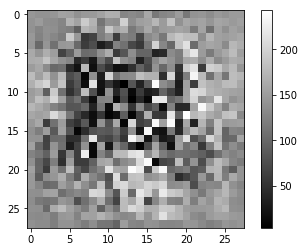

In [72]:
fake_im_not_trained = fake_im_not_trained.detach().numpy() * 255
fake_im_not_trained = fake_im_not_trained.reshape((28,28))
plt.figure()
plt.imshow(fake_im_not_trained, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c2) Generator output after training

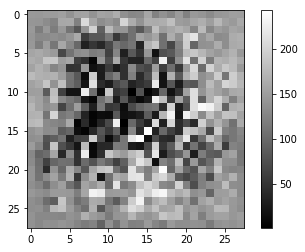

In [73]:
seed2 = torch.rand([1, 100, 1, 1])
generator.train(False)
fake_im = generator(seed2)
fake_im = fake_im.detach().numpy() * 255
fake_im = fake_im.reshape((28,28))
plt.figure()
plt.imshow(fake_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()